# 1. 의심거래들 중 그룹핑 되어 있는 것 확인

In [2]:
import os
import pandas as pd
import networkx as nx
from networkx.algorithms import community
from sklearn import preprocessing # 레이블 인코딩과 같은 전처리 작업을 수행


pd.set_option('display.max_columns', None)
path = '../../../../../archive/raw/HI-Small_Trans.csv'
org_df = pd.read_csv(path)
df = org_df

#### 0. 데이터 전처리
def preprocess( df):
    #df = df_label_encoder(df,['Payment Format', 'Payment Currency', 'Receiving Currency']) # 레이블 인코딩 : 해당 컬럼을 정수로 변환.
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp'] = df['Timestamp'].apply(lambda x: x.value)
    df['Timestamp'] = (df['Timestamp']-df['Timestamp'].min())/(df['Timestamp'].max()-df['Timestamp'].min()) # 1~0 사이 값으로 정규화

    df['Account'] = df['From Bank'].astype(str) + '_' + df['Account']
    df['Account.1'] = df['To Bank'].astype(str) + '_' + df['Account.1'] # 은행 정보와 결합하여 고유한 계정 식별자 생성
    df = df.sort_values(by=['Account'])
    receiving_df = df[['Account.1', 'Amount Received', 'Receiving Currency']] # 송금 및 수금 데이터를 분리.
    paying_df = df[['Account', 'Amount Paid', 'Payment Currency']]
    receiving_df = receiving_df.rename({'Account.1': 'Account'}, axis=1)
    currency_ls = sorted(df['Receiving Currency'].unique()) # 사용된 통화 종류 목록을 생성

    return df, receiving_df, paying_df, currency_ls



In [3]:
df, receiving_df, paying_df, currency_ls = preprocess(df)


In [4]:
df.rename({'Account': 'sender'}, axis=1 , inplace=True)
df.rename({'Account.1': 'receiver'}, axis=1, inplace=True)

In [5]:
#### 1. 의심거래 데이터만 필터링
suspect_df = df[df['Is Laundering']==1]

In [6]:
pd.set_option('display.max_columns', None)

suspect_df

,Timestamp,From Bank,sender,To Bank,receiver,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
317703,0.192631,10057,10057_803DE1580,28628,28628_80ACEE280,11364.12,Australian Dollar,11364.12,Australian Dollar,ACH,1
678519,0.083078,10057,10057_803F405F0,3144,3144_801C3C0D0,7561.88,US Dollar,7561.88,US Dollar,ACH,1
1469570,0.100872,10057,10057_803FEFF90,3,3_802A4BBD0,7802.52,Yuan,7802.52,Yuan,ACH,1
1310428,0.069919,10057,10057_80435C9F0,29467,29467_80435CA90,3137672.39,Yen,3137672.39,Yen,ACH,1
4763838,0.589324,10057,10057_80C3B78E0,1501,1501_8018C8AF0,16411.27,Euro,16411.27,Euro,ACH,1
...,...,...,...,...,...,...,...,...,...,...,...
2316309,0.228533,9679,9679_804688C10,11687,11687_8046894F0,378943.66,Yen,378943.66,Yen,ACH,1
3227728,0.336436,9,9_80615B3D0,10,10_80617B250,177673.93,Ruble,177673.93,Ruble,ACH,1
4908776,0.722406,9,9_8061AD3B0,11128,11128_80465E020,290938.96,Yen,290938.96,Yen,ACH,1
1928496,0.334472,9,9_806FA9C10,139342,139342_80EB1E930,7645.05,Swiss Franc,7645.05,Swiss Franc,ACH,1


In [7]:
# 가중치 없는 그래프 생성 
suspect_nx_graph = nx.from_pandas_edgelist(suspect_df, 'sender', 'receiver', create_using=nx.Graph())
communities = community.greedy_modularity_communities(suspect_nx_graph)
print("가중치 없는 그래프 커뮤니티 탐지 완료")


# # 거래 횟수 가중치 그래프 생성 
# suspect_nx_graph_weighted_count = nx.from_pandas_edgelist(
#     suspect_df, 'sender', 'receiver', edge_attr=True, create_using=nx.Graph()
# )

# edge_weights_count = suspect_df.groupby(['sender', 'receiver']).size().reset_index(name='weight')
# nx.set_edge_attributes(suspect_nx_graph_weighted_count, {(row['sender'], row['receiver']): row['weight'] for idx, row in edge_weights_count.iterrows()}, 'weight')


# communities_edge_weights = community.greedy_modularity_communities(suspect_nx_graph_weighted_count, weight='weight') # weight='weight' 추가
# print("거래 횟수 가중치 그래프 커뮤니티 탐지 완료")


# # 거래 금액 가중치 그래프 생성  (Amount Paid 사용)
# suspect_nx_graph_weighted_amount = nx.from_pandas_edgelist(
#     suspect_df, 'sender', 'receiver', ['Amount Paid'], create_using=nx.Graph()
# )

# communities_weighted_amount = community.greedy_modularity_communities(suspect_nx_graph_weighted_amount, weight='Amount Paid') # weight='Amount Paid' 추가
# print("거래 금액 가중치 그래프 커뮤니티 탐지 완료")


print("\n--- 커뮤니티 탐지 결과 ---")
print("\n1. 가중치 없는 그래프 커뮤니티:")
print(communities)
# print("\n2. 거래 횟수 가중치 그래프 커뮤니티:")
# print(communities_edge_weights)
# print("\n3. 거래 금액 가중치 그래프 커뮤니티:")
# print(communities_weighted_amount)

가중치 없는 그래프 커뮤니티 탐지 완료

--- 커뮤니티 탐지 결과 ---

1. 가중치 없는 그래프 커뮤니티:
[frozenset({'19888_8089B1C60', '15916_80E131230', '12381_80352E390', '1362_800CEA850', '12719_80C798460', '6179_80AA7BFF0', '1411_80407A190', '30775_80F2F7770', '37964_80E158220', '24132_802CDD790', '14077_802565AF0', '221891_809930160', '27444_803192310', '21258_803F0F700', '1_800057620', '3149_80A3807D0', '25547_806705C70', '17327_80724FA90', '16606_806D3B040', '29279_80475E4D0', '21940_802C641F0', '18324_809FFE610', '17729_805447960', '5836_81336FCC0', '1244_802E02D00', '10_80D820550', '28771_80E4039F0', '9371_80E49E460', '4766_8072C1AE0', '211050_810B20FC0', '236046_80E05DDF0', '21611_80D125D70', '31208_80C250BD0', '4503_8112167F0', '19329_8106C6310', '18511_809339760', '1411_8008CF190', '21174_805AE5230', '33389_80DE37D50', '11813_80ED33D50', '3229_80593F210', '1292_8051A4680', '220_805822770', '236046_81284CD80', '15980_80B39E7B0', '15916_804A799C0', '28771_80762F540', '122151_81112BB40', '16586_813B9CA10', '248047_81

* 각각의 frozenset이 하나의 커뮤니티를 나타내고, frozenset 안에 있는 문자열들은 해당 커뮤니티에 속하는 계좌 ID들을 의미

In [8]:
#### 2. 커뮤니티 크기 분포 확인
###### 2.1 가중치 없는 그래프 커뮤니티
community_sizes = [len(c) for c in communities]
print(f"가중치 없는 그래프 커뮤니티 통계:")
print(pd.Series(community_sizes).describe())

가중치 없는 그래프 커뮤니티 통계:
count    1847.000000
mean        3.441798
std         8.098777
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max       241.000000
dtype: float64


# 2. 커뮤니티 내부 계좌 특징 분석
* 각 커뮤니티별로 suspect_df 데이터를 추출, 커뮤니티 내부 계좌들의 공통적인 특징을 분석.
* 특정 커뮤니티에 속한 계좌들의 From Bank, To Bank, Payment Format, Payment Currency, Receiving Currency 등의 컬럼 값 분포 확인
* 의심 거래 데이터프레임(suspect_df)에서 각 커뮤니티에 속하는 계좌들의 데이터를 필터링하고, 통계치 (평균, 중앙값, 최빈값 등) 또는 시각화 (막대 그래프, 파이 차트 등) -> 특징을 비교 분석.

### 2.1 가중치 없는 커뮤니티 분석

In [9]:
for i, community_set in enumerate(communities):
    print(f"\n------------ 커뮤니티 {i+1} 분석 ------------")
    community_df = suspect_df[suspect_df['sender'].isin(community_set) | suspect_df['receiver'].isin(community_set)] # sender 또는 receiver 중 하나라도 커뮤니티에 속하면 해당 거래 포함
    
    print(f"커뮤니티 크기: {len(community_set)}, 거래 건수: {len(community_df)}")

    #  Payment Format 분포 확인
    payment_format_counts = community_df['Payment Format'].value_counts()
    print("\nPayment Format 분포:")
    print(payment_format_counts)

    # Receiving Currency 분포 확인
    receiving_currency_counts = community_df['Payment Currency'].value_counts()
    print("\nPayment Currency 분포:")
    print(receiving_currency_counts)


    # Receiving Currency 분포 확인
    receiving_currency_counts = community_df['Receiving Currency'].value_counts()
    print("\nReceiving Currency 분포:")
    print(receiving_currency_counts)


------------ 커뮤니티 1 분석 ------------
커뮤니티 크기: 241, 거래 건수: 247

Payment Format 분포:
Cheque         114
Credit Card     90
Cash            39
ACH              4
Name: Payment Format, dtype: int64

Payment Currency 분포:
US Dollar    247
Name: Payment Currency, dtype: int64

Receiving Currency 분포:
US Dollar    247
Name: Receiving Currency, dtype: int64

------------ 커뮤니티 2 분석 ------------
커뮤니티 크기: 167, 거래 건수: 169

Payment Format 분포:
Cheque         83
Credit Card    52
Cash           23
ACH            11
Name: Payment Format, dtype: int64

Payment Currency 분포:
Euro                 162
US Dollar              6
Australian Dollar      1
Name: Payment Currency, dtype: int64

Receiving Currency 분포:
Euro                 162
US Dollar              6
Australian Dollar      1
Name: Receiving Currency, dtype: int64

------------ 커뮤니티 3 분석 ------------
커뮤니티 크기: 57, 거래 건수: 59

Payment Format 분포:
ACH    59
Name: Payment Format, dtype: int64

Payment Currency 분포:
Euro            48
US Dollar        8
Mexic

* 대부분의 커뮤니티 크기가 작은 것을 보아, 의심 거래 네트워크가 매우 세분화된 작은 그룹들로 구성되어 있을 가능성을 추측해 볼 수 있음.


------------ Community 1 Analysis ------------
커뮤니티 크기 : 241, 거래 건수 : 247


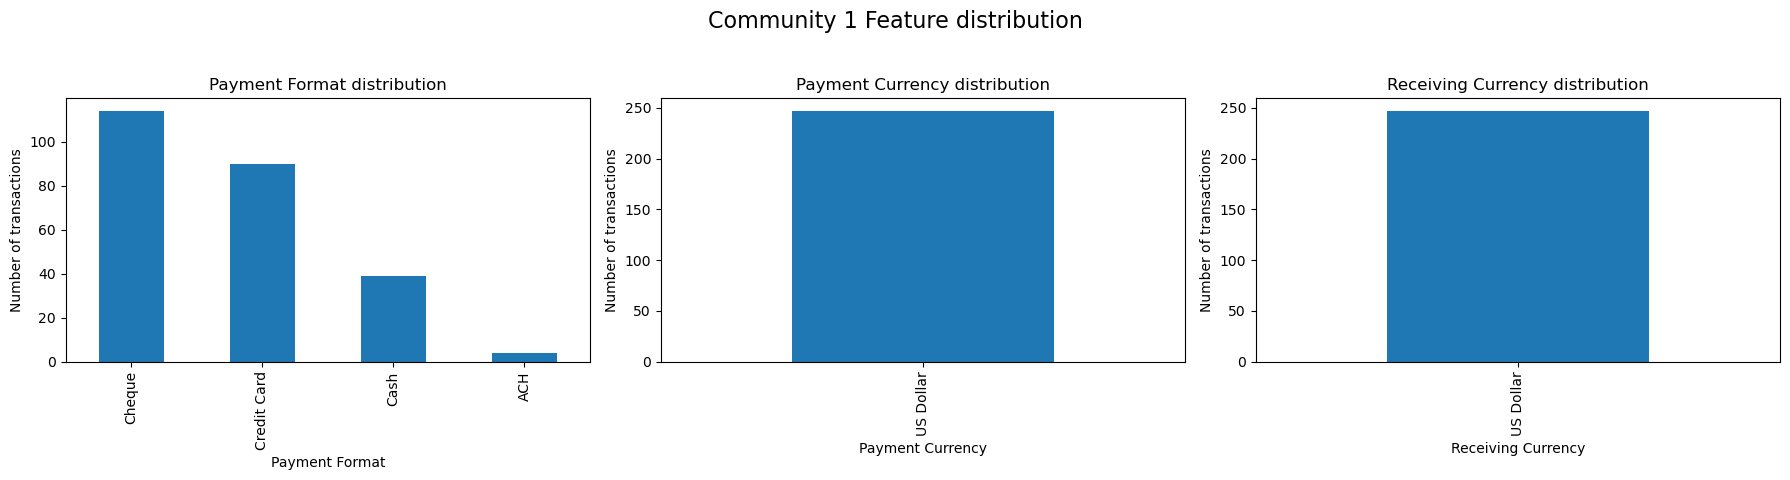


------------ Community 2 Analysis ------------
커뮤니티 크기 : 167, 거래 건수 : 169


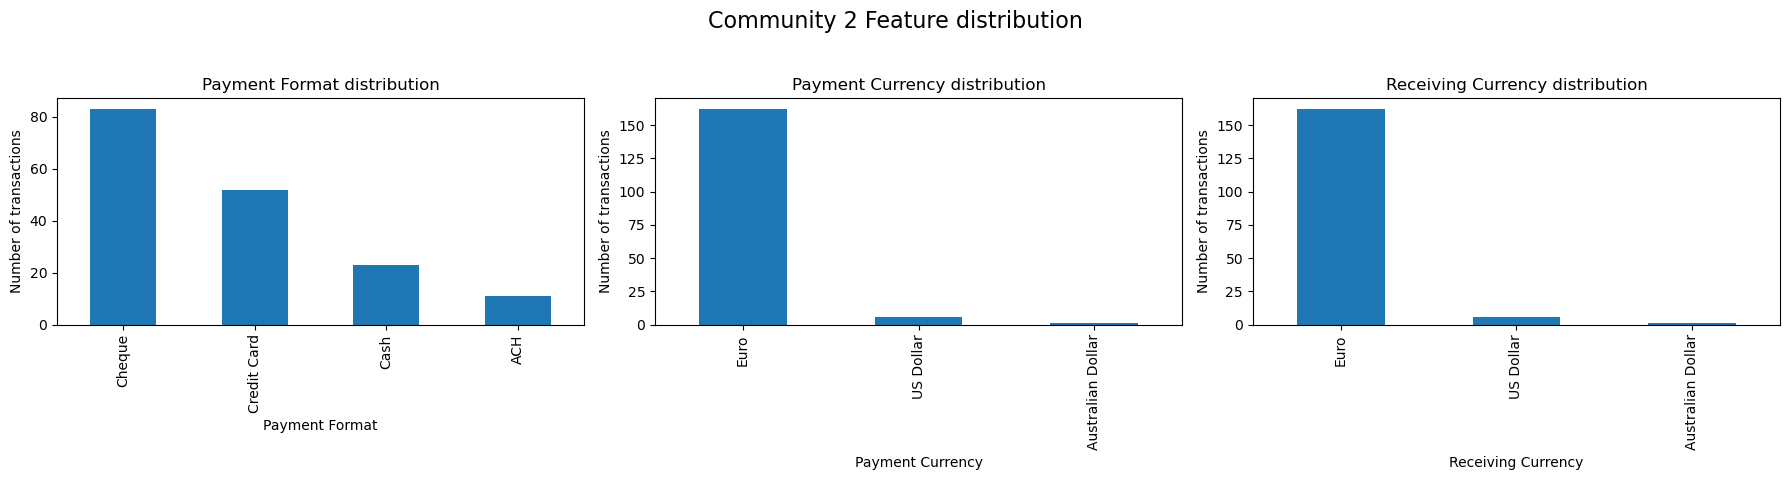


------------ Community 3 Analysis ------------
커뮤니티 크기 : 57, 거래 건수 : 59


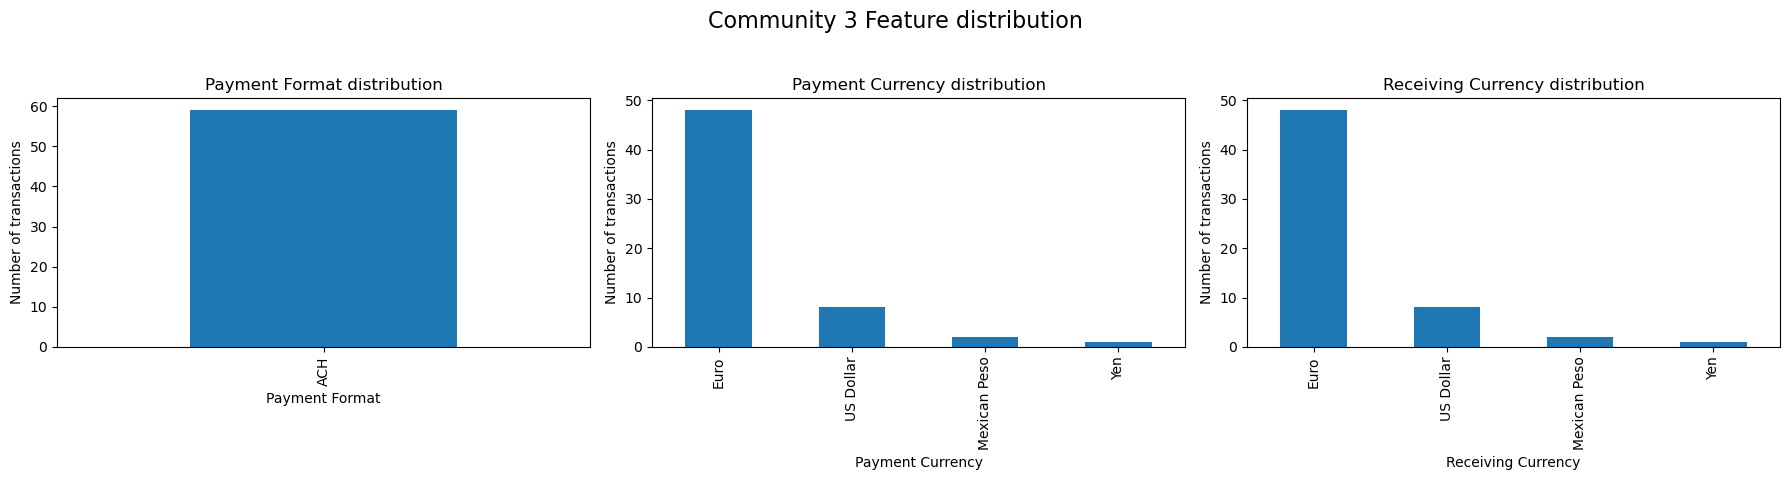


------------ Community 4 Analysis ------------
커뮤니티 크기 : 54, 거래 건수 : 54


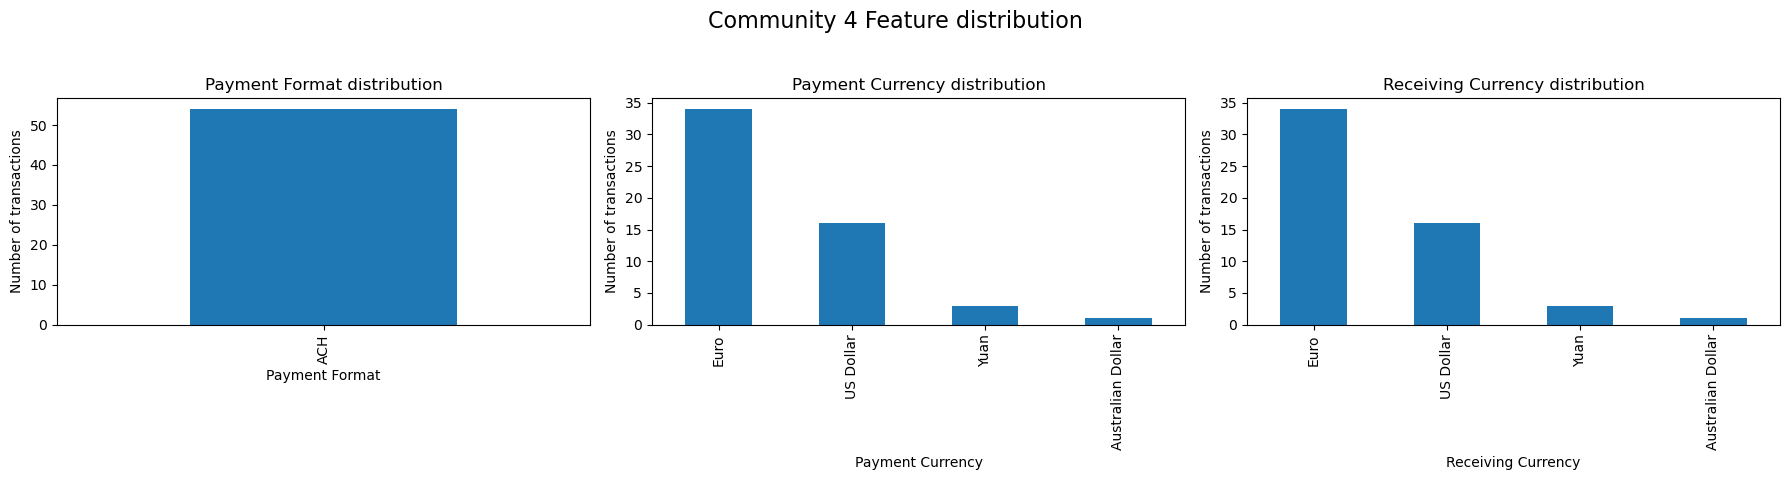


------------ Community 5 Analysis ------------
커뮤니티 크기 : 52, 거래 건수 : 55


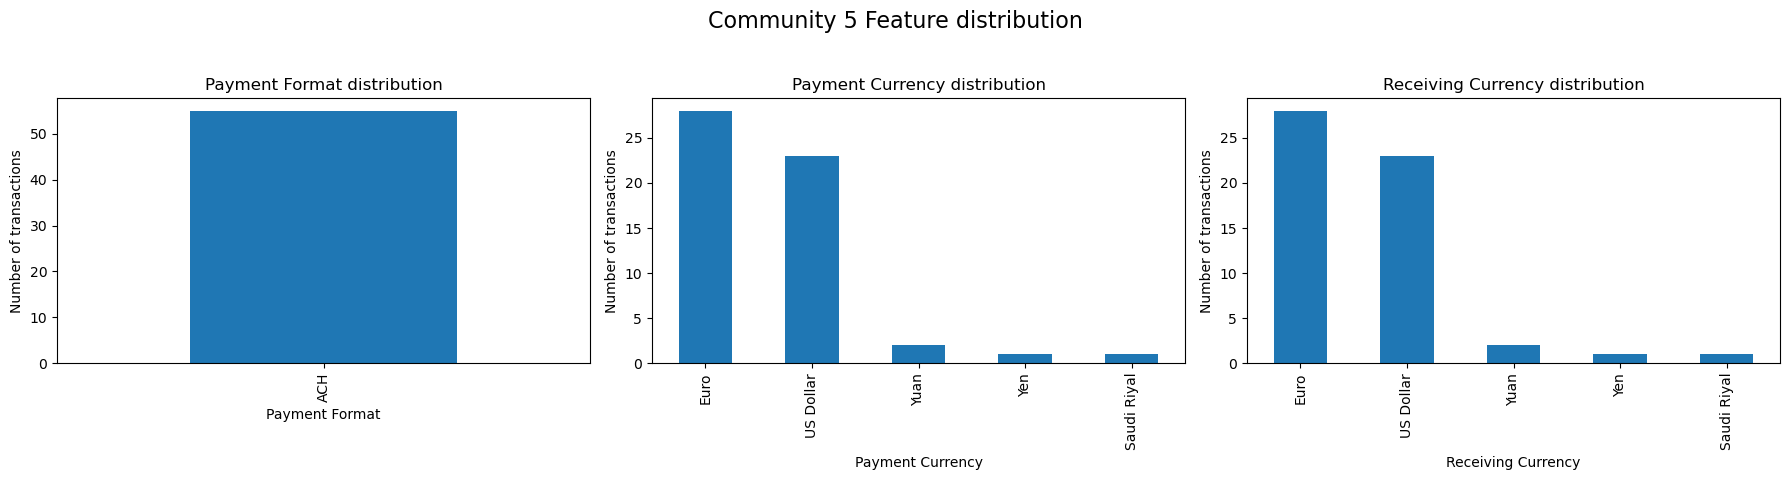


------------ Community 6 Analysis ------------
커뮤니티 크기 : 50, 거래 건수 : 49


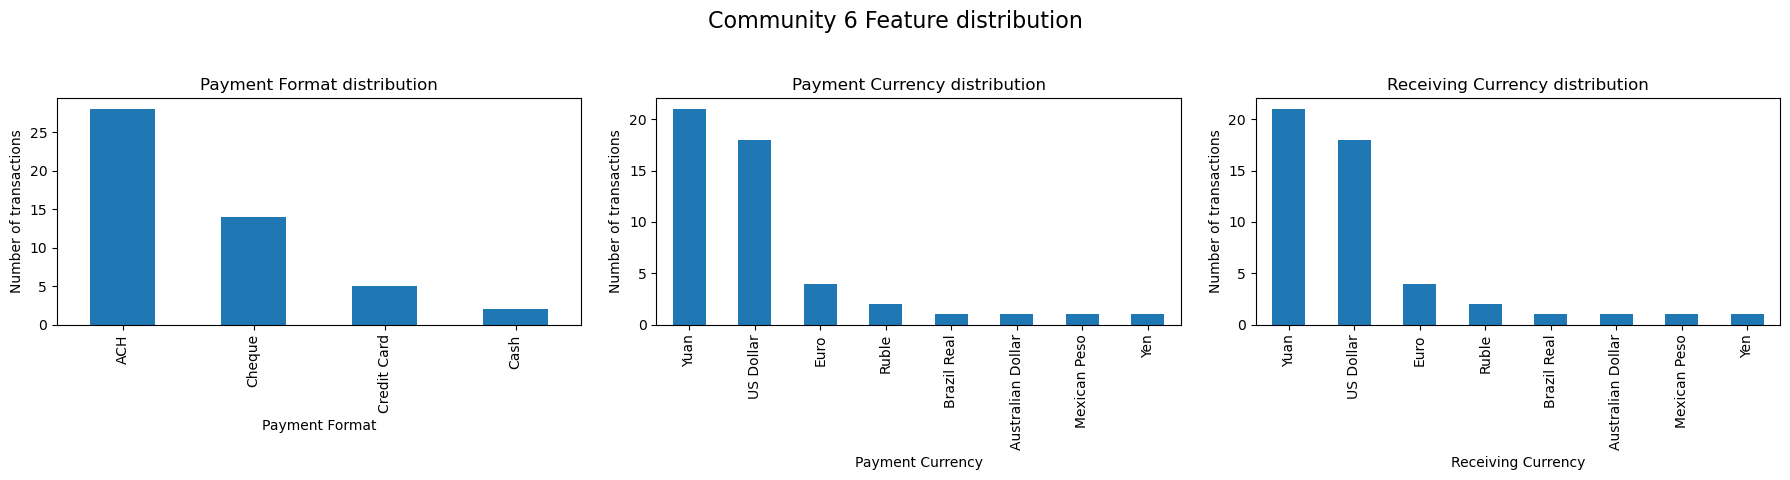


------------ Community 7 Analysis ------------
커뮤니티 크기 : 43, 거래 건수 : 54


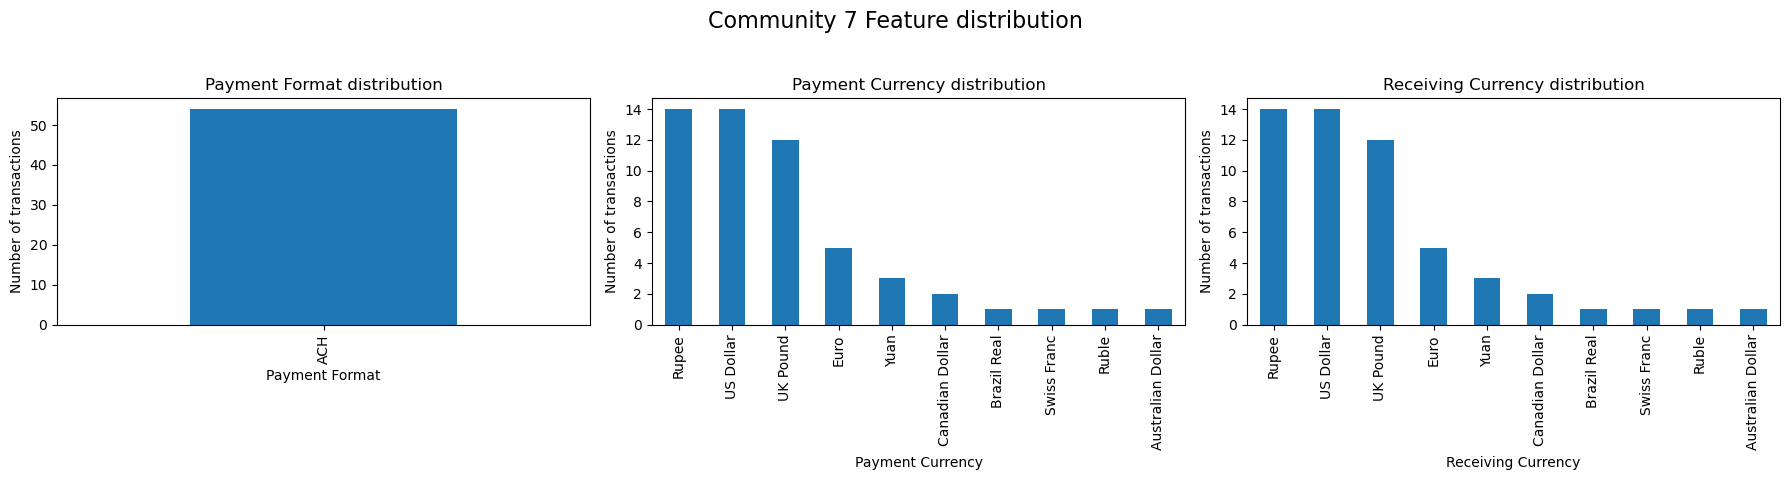


------------ Community 8 Analysis ------------
커뮤니티 크기 : 42, 거래 건수 : 41


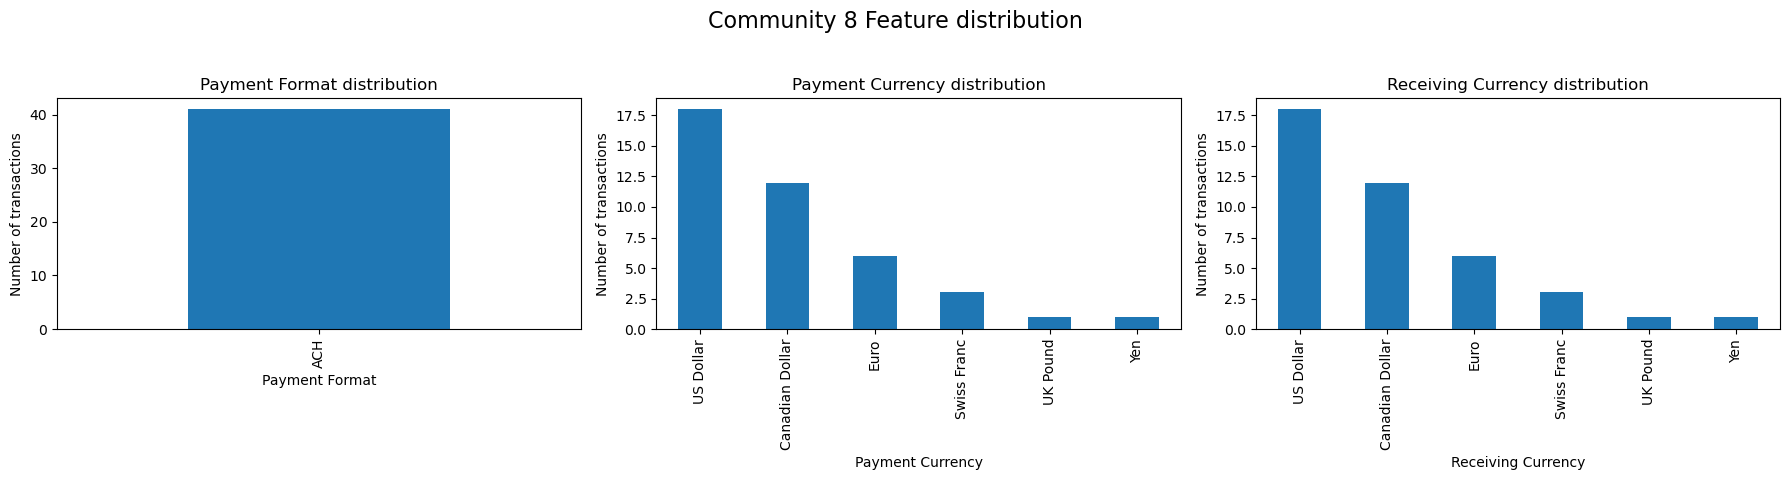


------------ Community 9 Analysis ------------
커뮤니티 크기 : 39, 거래 건수 : 146


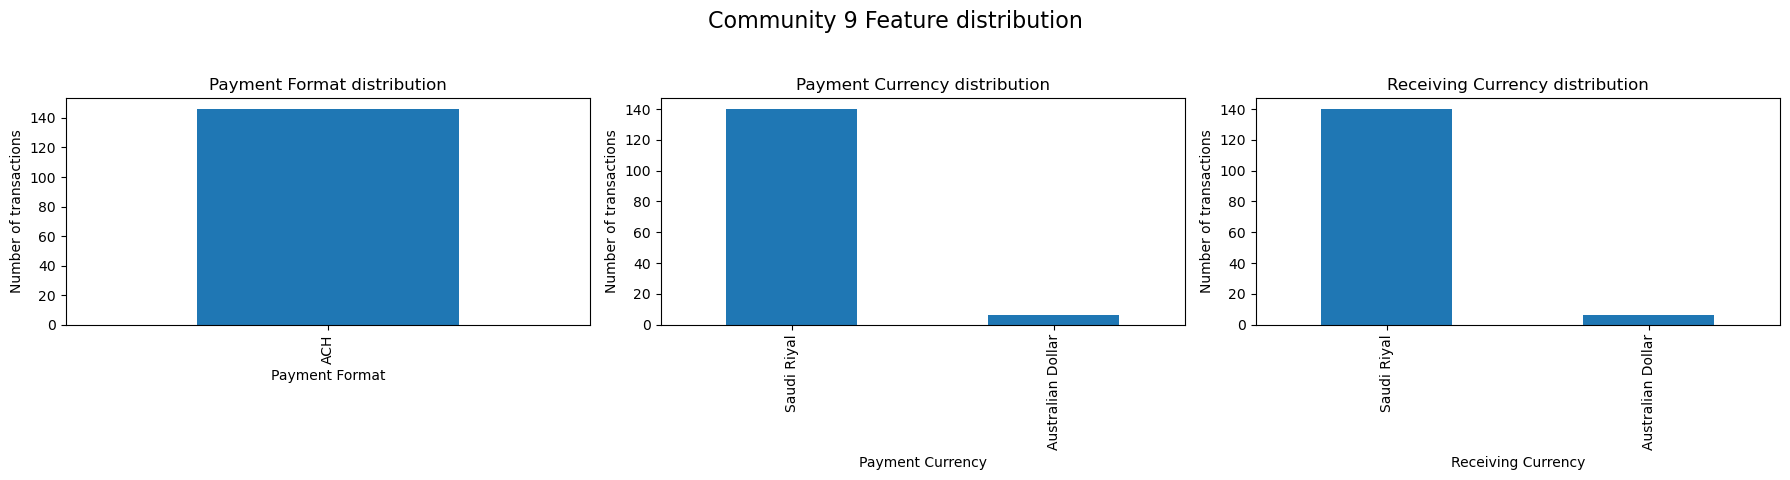


------------ Community 10 Analysis ------------
커뮤니티 크기 : 37, 거래 건수 : 47


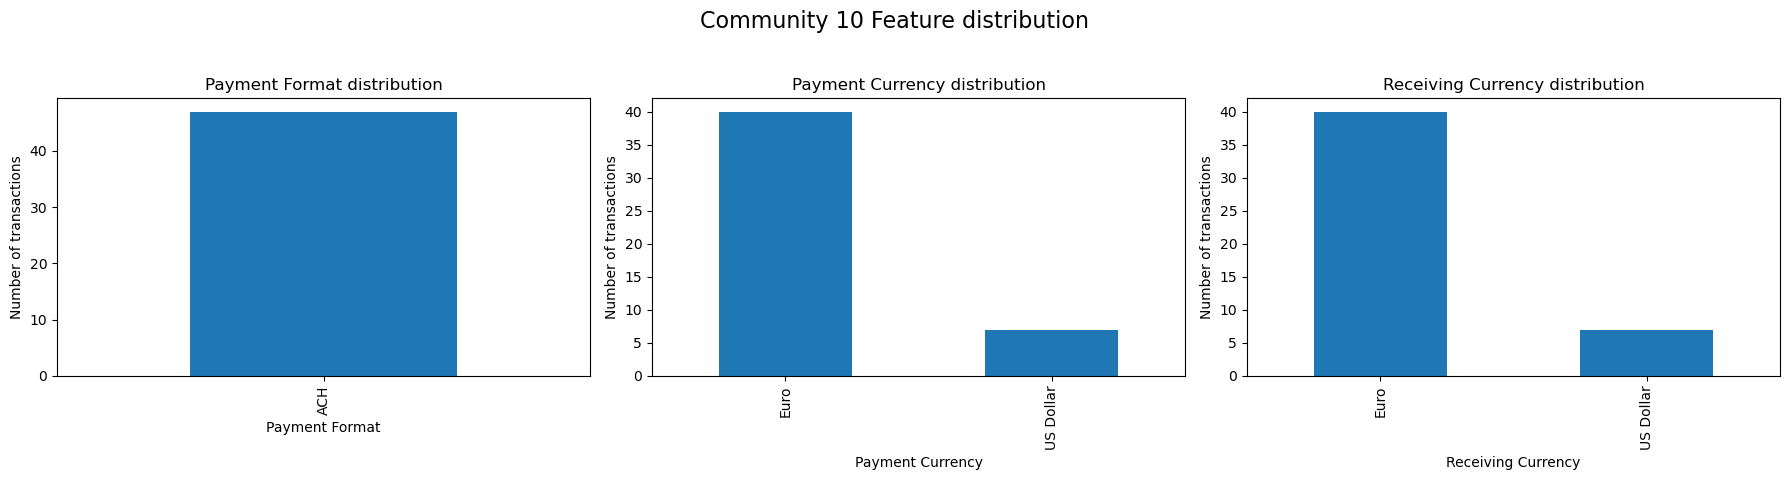


------------ Community 11 Analysis ------------
커뮤니티 크기 : 35, 거래 건수 : 45


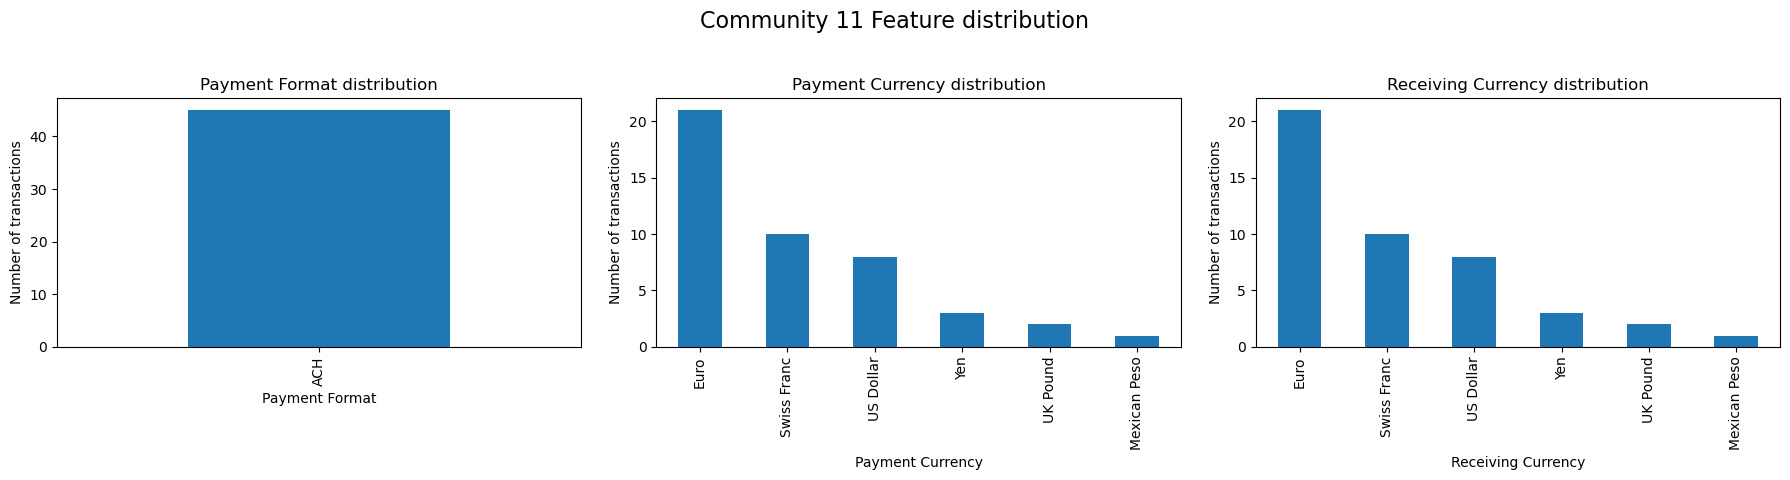


------------ Community 12 Analysis ------------
커뮤니티 크기 : 30, 거래 건수 : 29


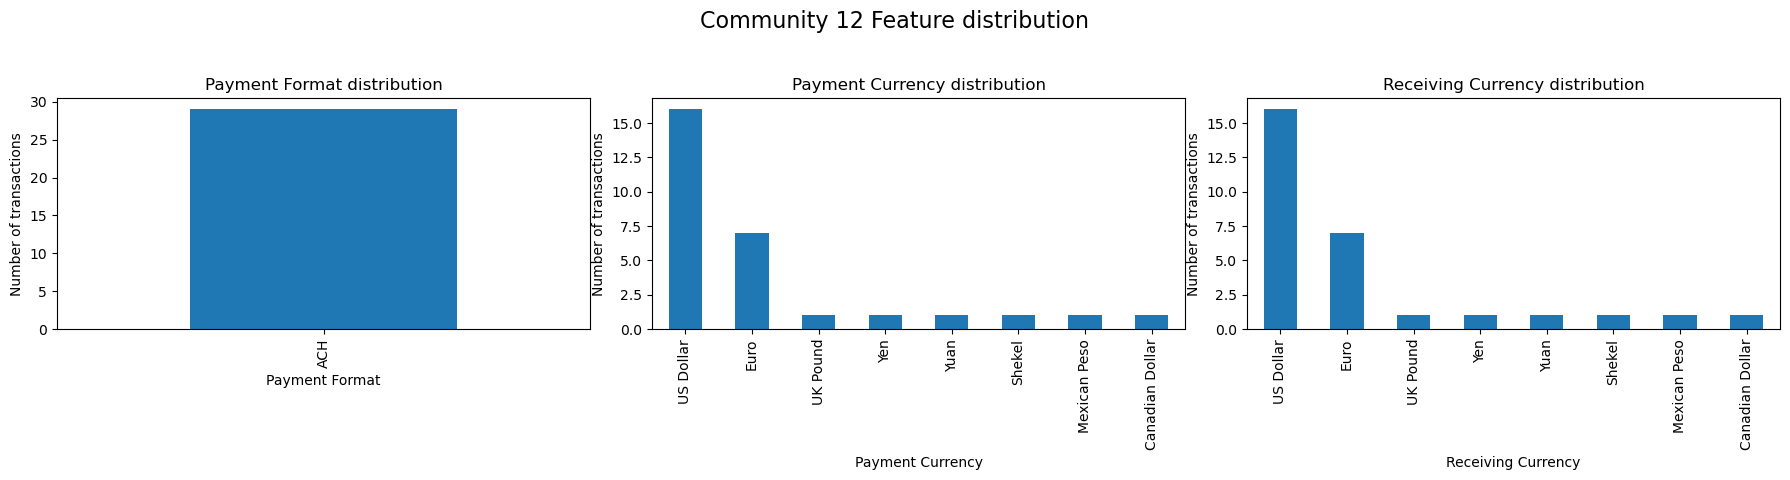


------------ Community 13 Analysis ------------
커뮤니티 크기 : 30, 거래 건수 : 29


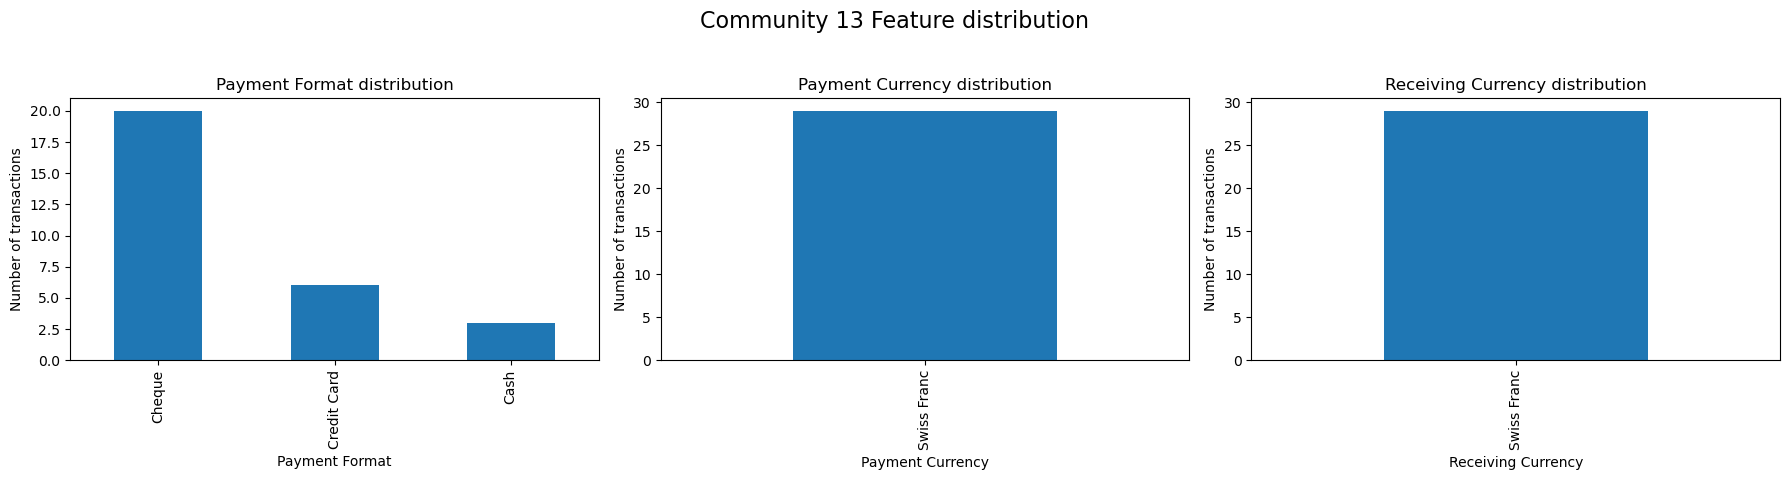


------------ Community 14 Analysis ------------
커뮤니티 크기 : 28, 거래 건수 : 27


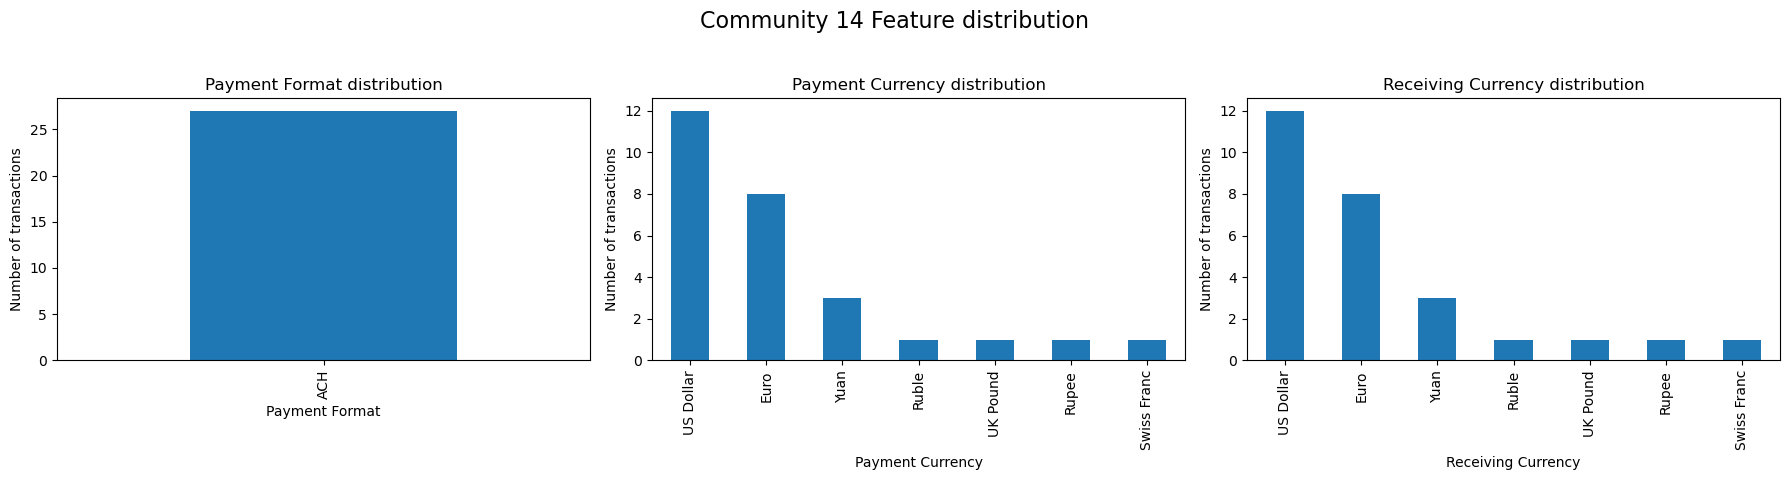


------------ Community 15 Analysis ------------
커뮤니티 크기 : 28, 거래 건수 : 27


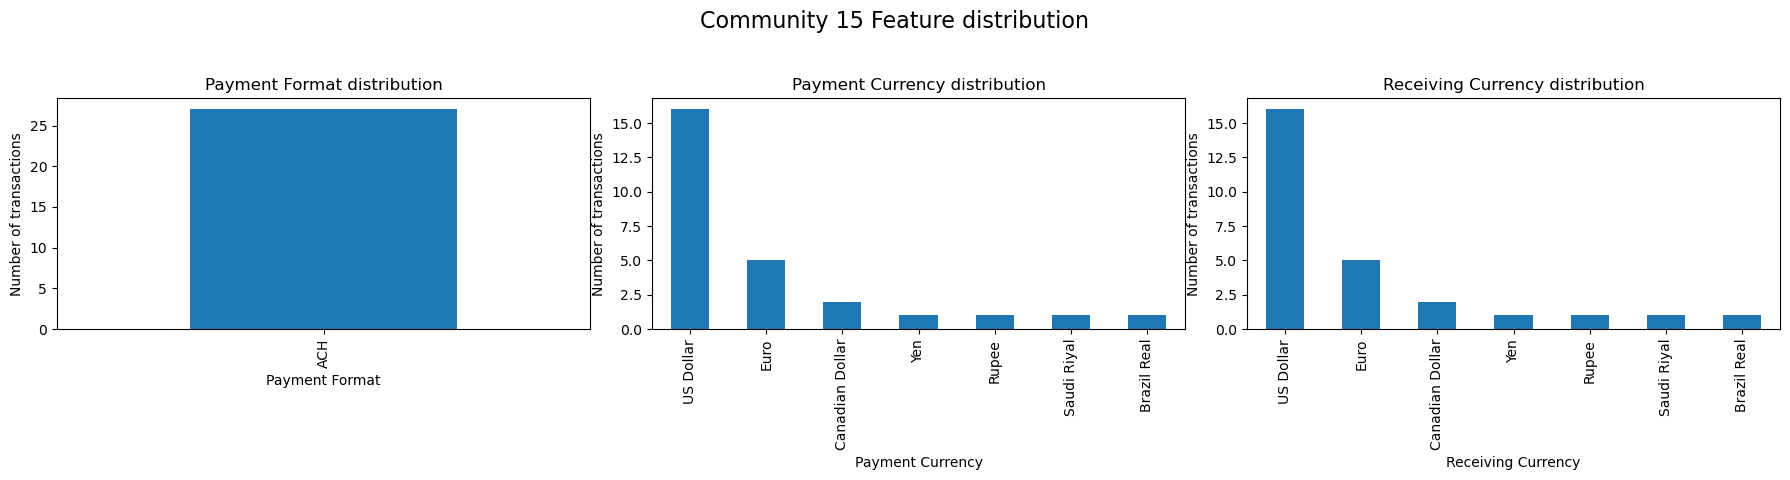


------------ Community 16 Analysis ------------
커뮤니티 크기 : 27, 거래 건수 : 26


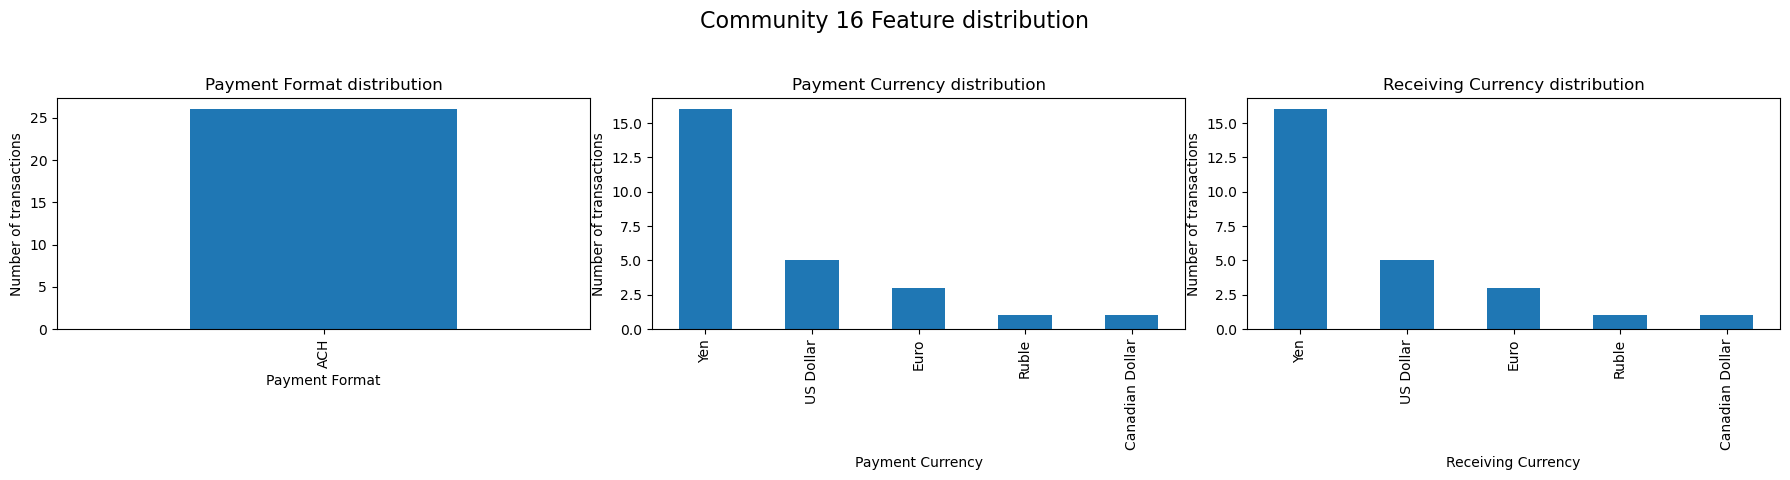


------------ Community 17 Analysis ------------
커뮤니티 크기 : 27, 거래 건수 : 26


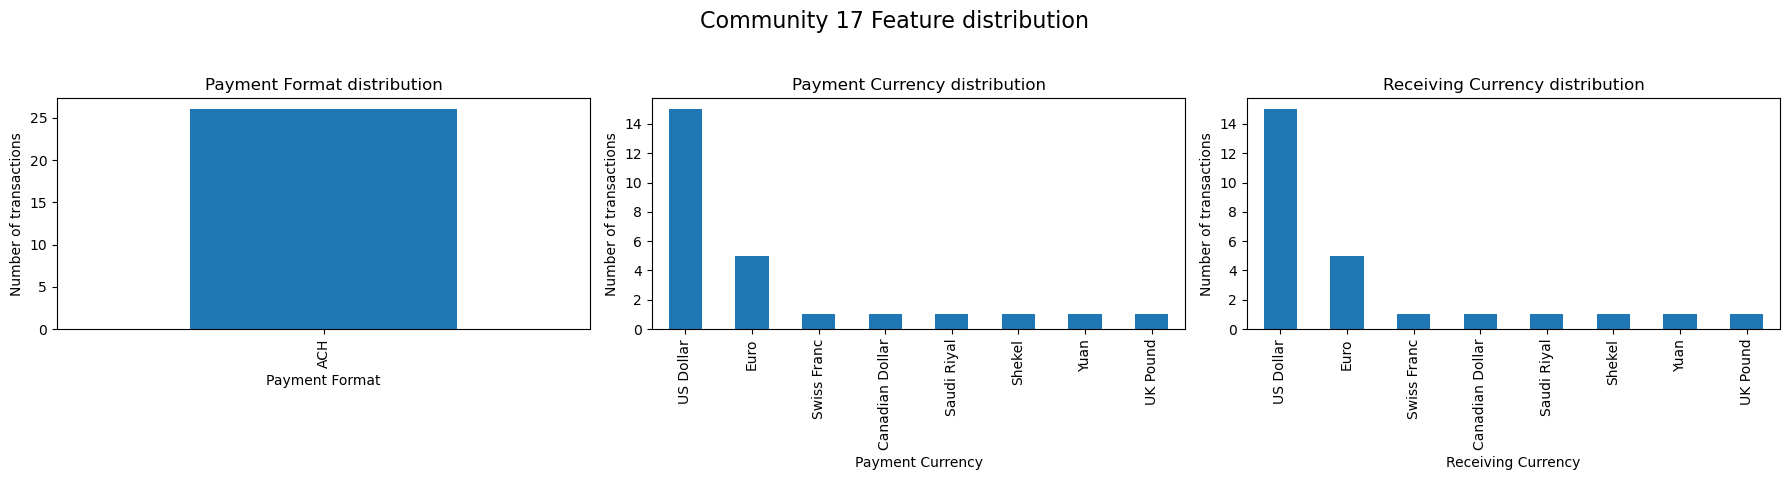


------------ Community 18 Analysis ------------
커뮤니티 크기 : 27, 거래 건수 : 26


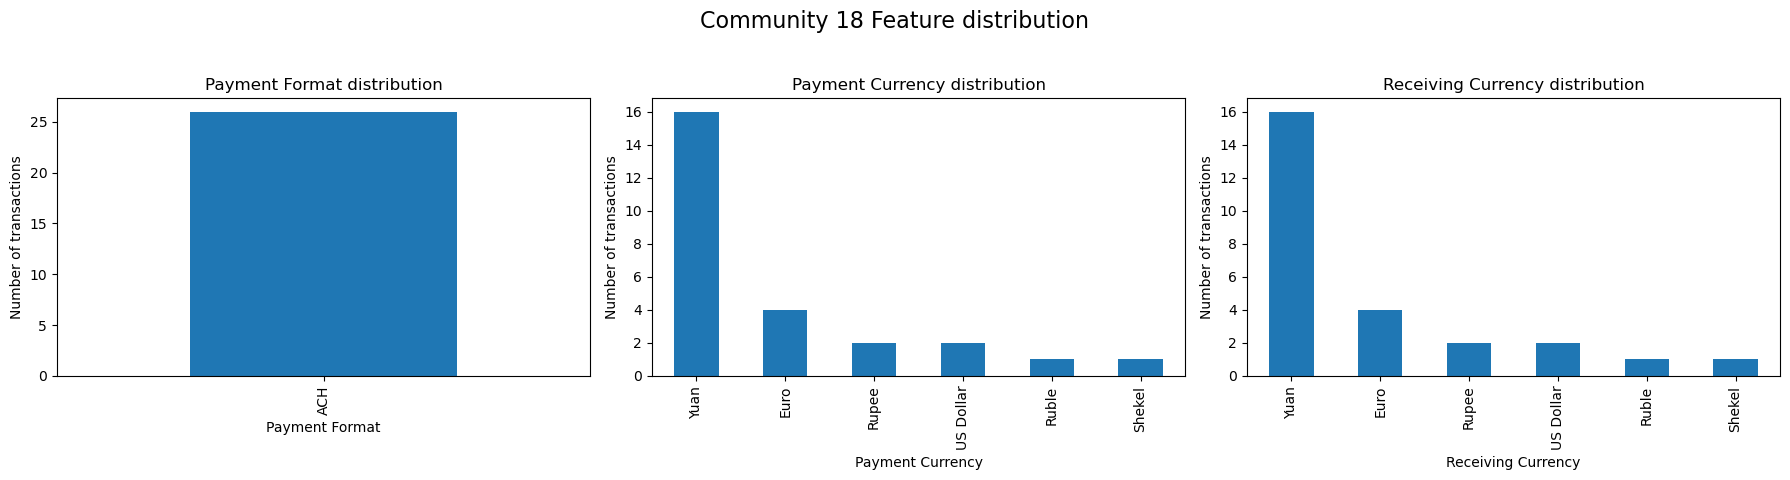


------------ Community 19 Analysis ------------
커뮤니티 크기 : 27, 거래 건수 : 26


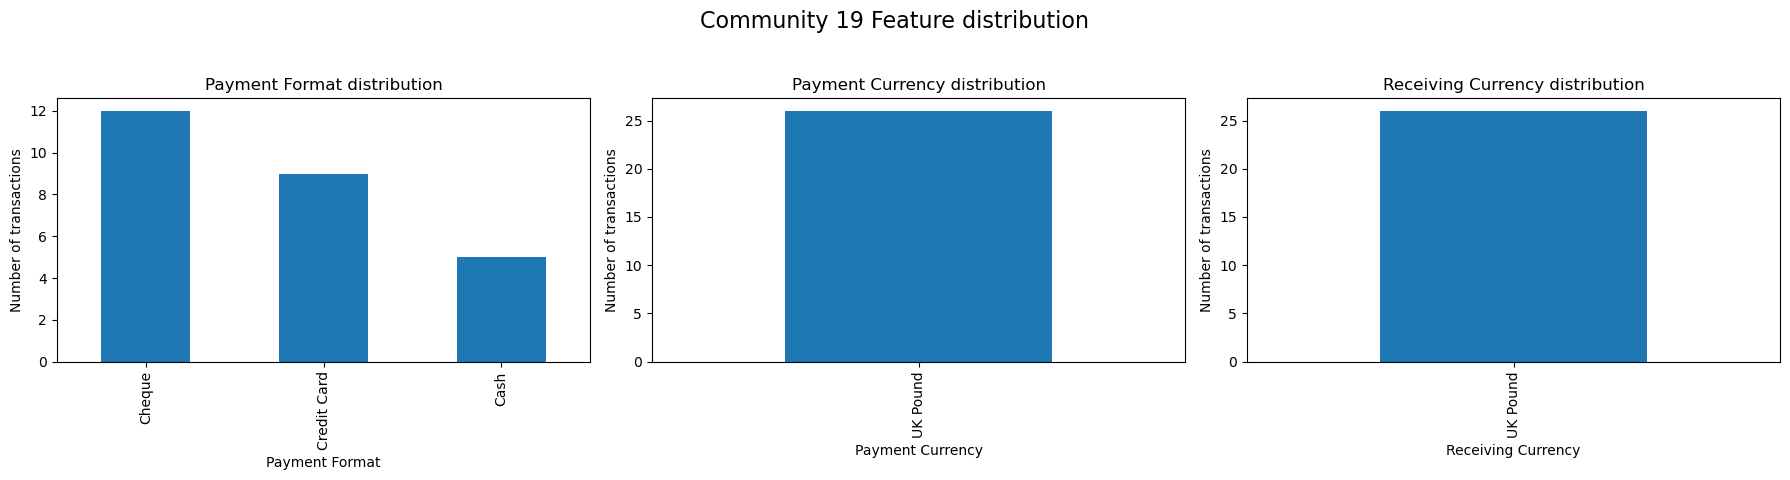


------------ Community 20 Analysis ------------
커뮤니티 크기 : 25, 거래 건수 : 24


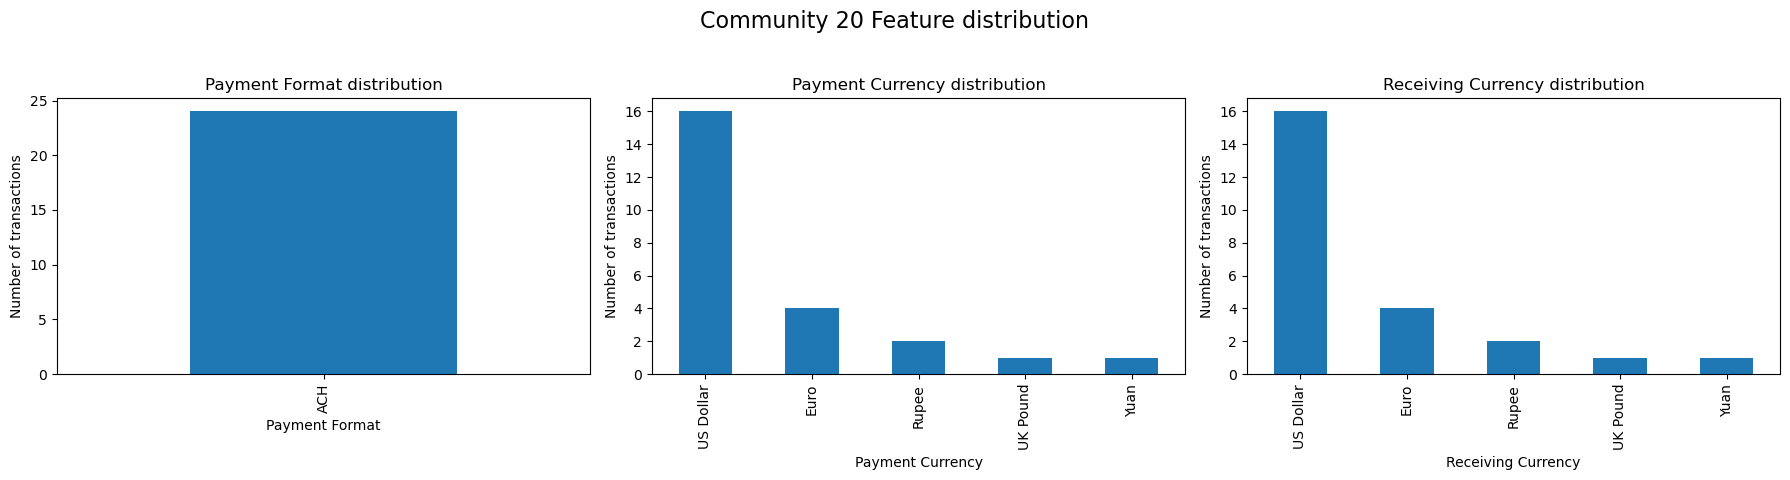


------------ Community 21 Analysis ------------
커뮤니티 크기 : 25, 거래 건수 : 24


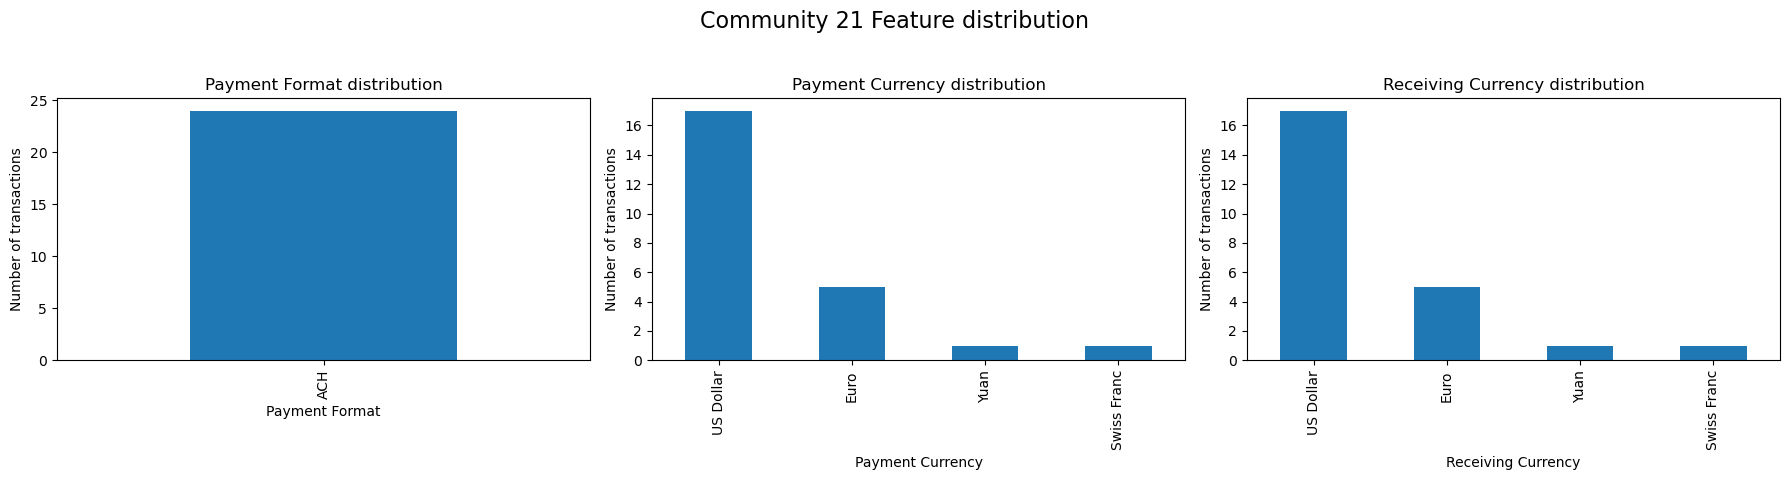


------------ Community 22 Analysis ------------
커뮤니티 크기 : 24, 거래 건수 : 24


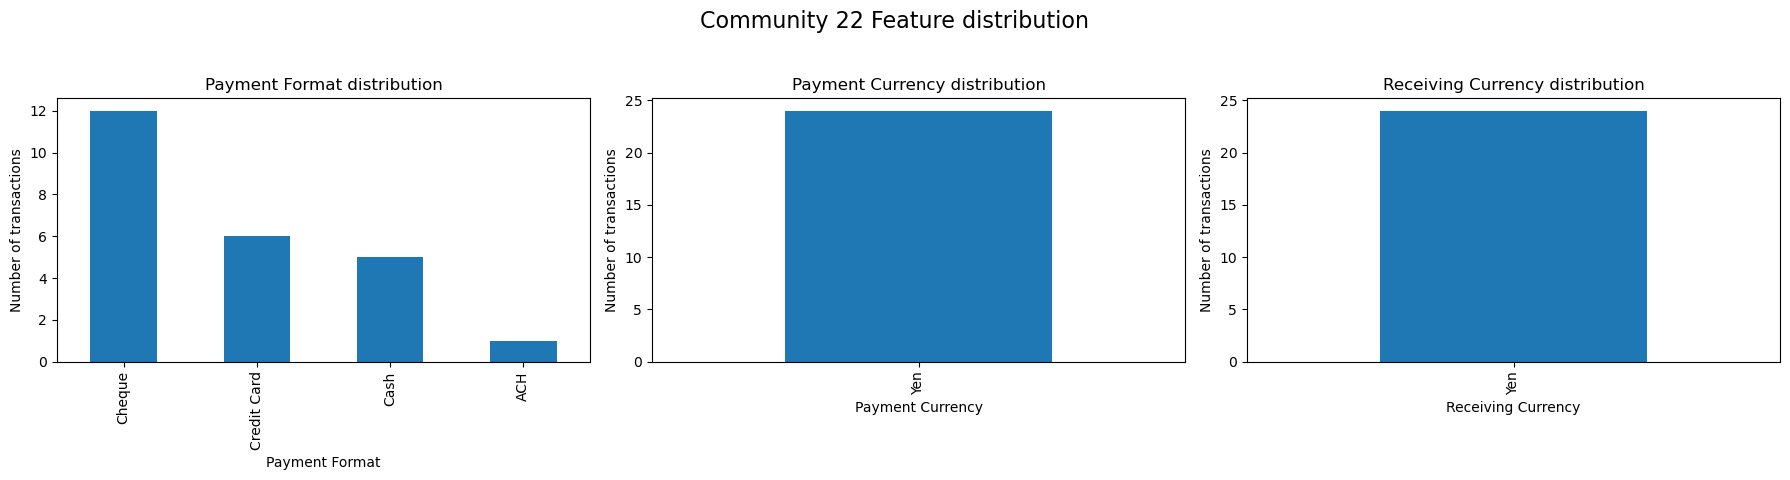


------------ Community 23 Analysis ------------
커뮤니티 크기 : 24, 거래 건수 : 23


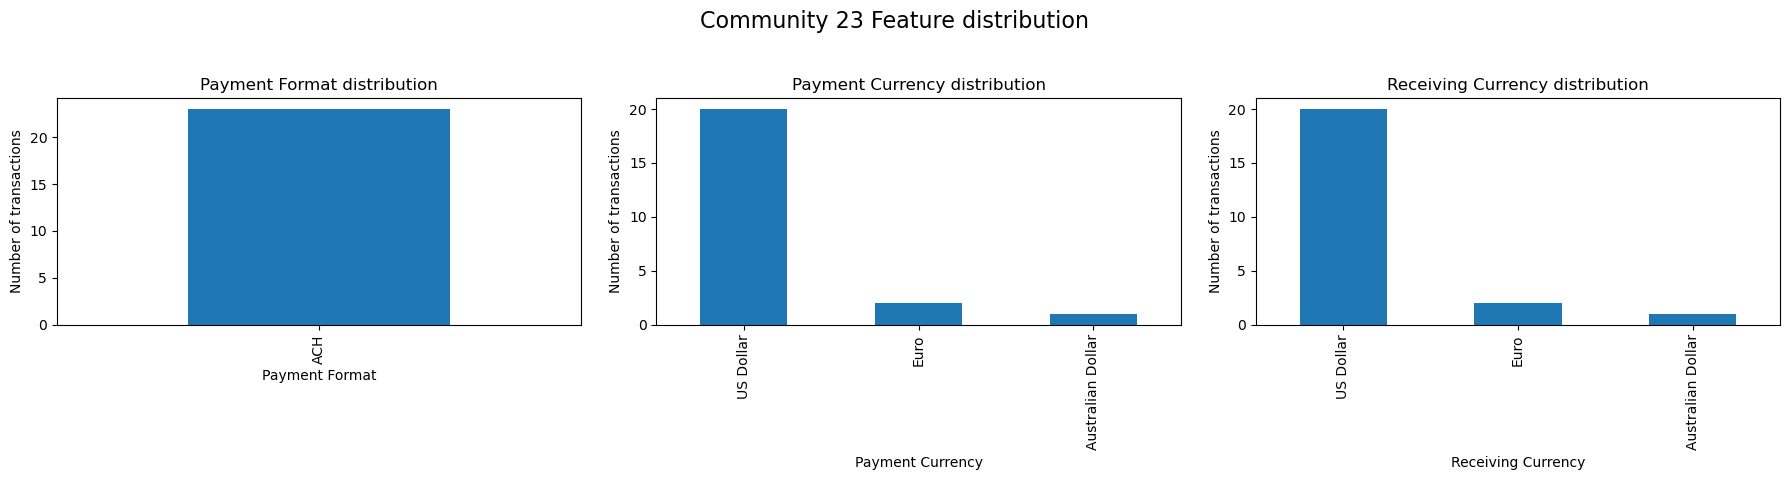


------------ Community 24 Analysis ------------
커뮤니티 크기 : 23, 거래 건수 : 22


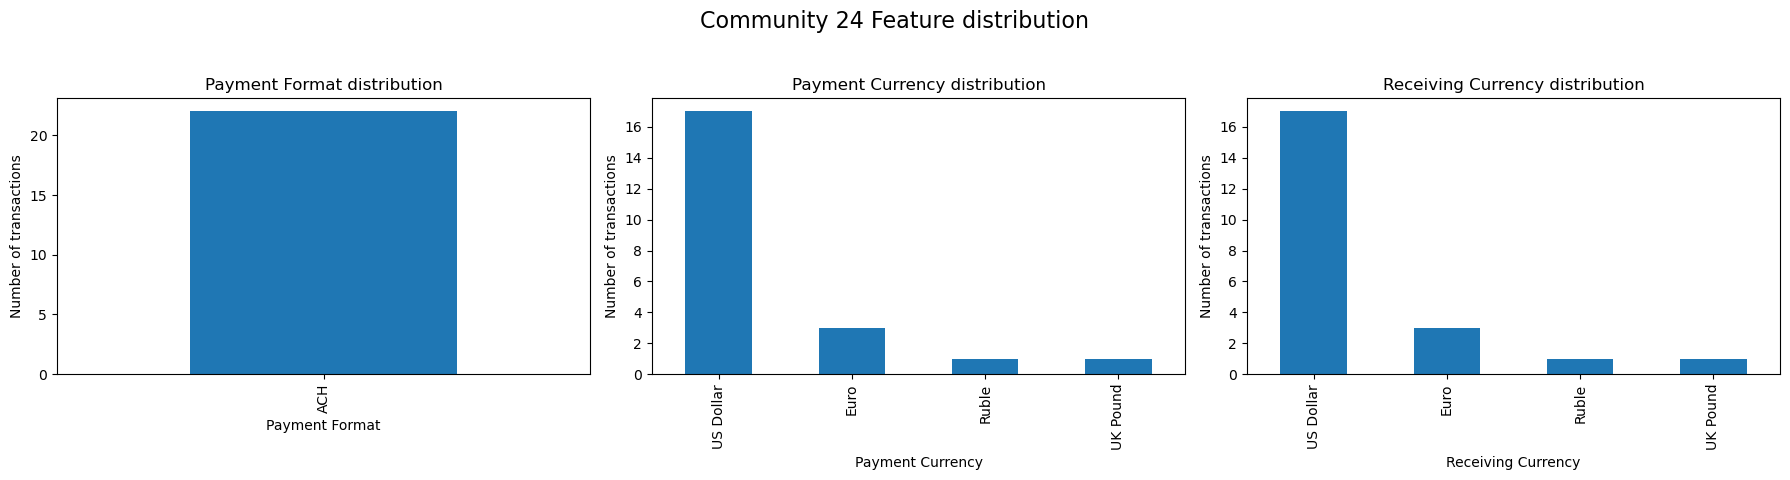


------------ Community 25 Analysis ------------
커뮤니티 크기 : 23, 거래 건수 : 23


KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

for i, community_set in enumerate(communities):
    print(f"\n------------ Community {i+1} Analysis ------------")
    community_df = suspect_df[suspect_df['sender'].isin(community_set) | suspect_df['receiver'].isin(community_set)]
    print(f"커뮤니티 크기 : {len(community_set)}, 거래 건수 : {len(community_df)}")

    # 시각화 준비
    fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # 1행 3열 그래프 생성
    fig.suptitle(f'Community {i+1} Feature distribution', fontsize=16)

    # 1. Payment Format 분포 막대 그래프
    payment_format_counts = community_df['Payment Format'].value_counts()
    payment_format_counts.plot(kind='bar', ax=axes[0])
    axes[0].set_title('Payment Format distribution')
    axes[0].set_xlabel('Payment Format')
    axes[0].set_ylabel('Number of transactions')

    # 2. Payment Currency 분포 막대 그래프
    payment_currency_counts = community_df['Payment Currency'].value_counts()
    payment_currency_counts.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Payment Currency distribution')
    axes[1].set_xlabel('Payment Currency')
    axes[1].set_ylabel('Number of transactions')

    # 3. Receiving Currency 분포 막대 그래프
    receiving_currency_counts = community_df['Receiving Currency'].value_counts()
    receiving_currency_counts.plot(kind='bar', ax=axes[2])
    axes[2].set_title('Receiving Currency distribution')
    axes[2].set_xlabel('Receiving Currency')
    axes[2].set_ylabel('Number of transactions')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 제목 때문에 레이아웃 조정
    plt.show()